In [29]:
import pandas as pd
#import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder  
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import log_loss, classification_report
#from sklearn.metrics import roc_curve, roc_auc_score

##### 1) EDA: Comprensión inicial del dataset, estadísticas descriptivas, identificación de variables, visualizaciones para entender distribuciones, correlaciones y posibles problemas como valores nulos o atípico.

Shape: (48532, 9)
Types:
 date          datetime64[ns]
home_team             object
away_team             object
home_score             int64
away_score             int64
tournament            object
city                  object
country               object
neutral                 bool
dtype: object
Head:
         date home_team away_team  home_score  away_score tournament     city  \
0 1872-11-30  Scotland   England           0           0   Friendly  Glasgow   
1 1873-03-08   England  Scotland           4           2   Friendly   London   
2 1874-03-07  Scotland   England           2           1   Friendly  Glasgow   
3 1875-03-06   England  Scotland           2           2   Friendly   London   
4 1876-03-04  Scotland   England           3           0   Friendly  Glasgow   

    country  neutral  
0  Scotland    False  
1   England    False  
2  Scotland    False  
3   England    False  
4  Scotland    False  
Tail:
             date               home_team away_team  home_score  aw

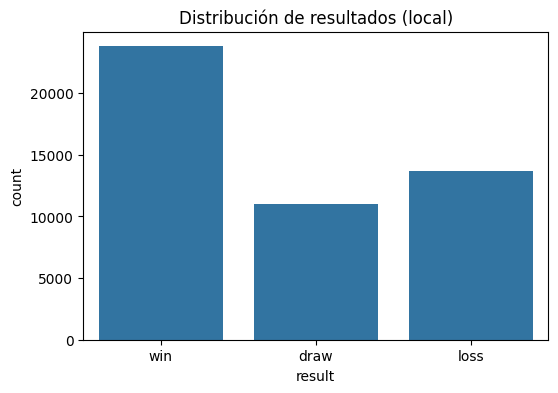

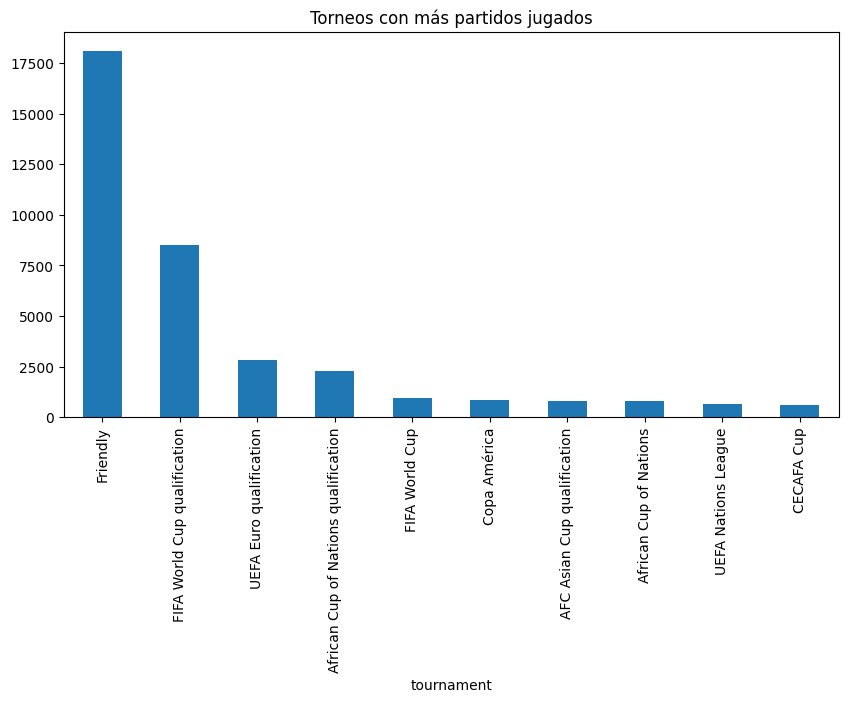

In [30]:
# Cargar datos
results = pd.read_csv("./archive/results.csv")
results["date"] = pd.to_datetime(results["date"])

print("Shape:", results.shape)
print("Types:\n", results.dtypes)
print("Head:\n", results.head())
print("Tail:\n", results.tail())
print("Describe:\n", results.describe())
print("Nulls:\n", results.isna().sum())

# Crear resultado (W/D/L) (desde la perspectiva del local)
results["result"] = results.apply(
    lambda row: "win" if row["home_score"] > row["away_score"] 
    else ("loss" if row["home_score"] < row["away_score"] else "draw"),
    axis=1
)

plt.figure(figsize=(6,4))
sns.countplot(data=results, x="result", order=["win","draw","loss"])
plt.title("Distribución de resultados (local)")
plt.show()

# Crear diferencia de goles
results["goal_diff"] = results["home_score"] - results["away_score"]

# Separemos el año y el mes
results["year"] = results["date"].dt.year
results["month"] = results["date"].dt.month

# Top torneos con más partidos
plt.figure(figsize=(10,5))
results["tournament"].value_counts().head(10).plot(kind="bar")
plt.title("Torneos con más partidos jugados")
plt.show()


 ##### 2) Preprocesamiento y Preparación de Datos: Descripción de las transformaciones aplicadas a los datos para prepararlos para el modelado. Esto incluye, pero no se limita a: limpieza de datos, imputación de valores faltantes, codificación de variables categóricas, escalado de características, etc.

In [31]:
# Función: calcula estadísticas recientes por equipo
def compute_team_form(df, team, date, window_years=3):
    """Devuelve winrate, goles a favor y goles en contra promedio
    de un equipo en los últimos window_years años antes de 'date'."""
    cutoff = date - pd.DateOffset(years=window_years)
    past_matches = df[
        ((df["home_team"] == team) | (df["away_team"] == team)) &
        (df["date"] < date) &
        (df["date"] >= cutoff)
    ]
    if past_matches.empty:
        return pd.Series([0.5, 1.0, 1.0])  # valores neutros de winrate, promedio de goles a favor y goles en contra
    
    # resultados desde perspectiva del team
    wins, draws, losses, gf, ga = 0, 0, 0, 0, 0
    for _, row in past_matches.iterrows():
        if row["home_team"] == team:
            gf += row["home_score"]
            ga += row["away_score"]
            if row["home_score"] > row["away_score"]:
                wins += 1
            elif row["home_score"] == row["away_score"]:
                draws += 1
            else:
                losses += 1
        else:  # team fue visitante
            gf += row["away_score"]
            ga += row["home_score"]
            if row["away_score"] > row["home_score"]:
                wins += 1
            elif row["away_score"] == row["home_score"]:
                draws += 1
            else:
                losses += 1
    
    total = wins + draws + losses
    winrate = wins / total if total > 0 else 0.5
    avg_gf = gf / total if total > 0 else 1.0
    avg_ga = ga / total if total > 0 else 1.0
    
    return pd.Series([winrate, avg_gf, avg_ga])


In [32]:
# Crear features de fuerza para cada partido
features = []
for idx, row in results.iterrows():
    home_stats = compute_team_form(results, row["home_team"], row["date"], window_years=3)
    away_stats = compute_team_form(results, row["away_team"], row["date"], window_years=3)
    
    features.append([
        row["home_team"], row["away_team"], row["date"], row["result"],
        home_stats[0], home_stats[1], home_stats[2],
        away_stats[0], away_stats[1], away_stats[2]
    ])

df_feat = pd.DataFrame(features, columns=[
    "home_team","away_team","date","result",
    "home_winrate","home_gf","home_ga",
    "away_winrate","away_gf","away_ga"
])

print(df_feat.head())

  home_team away_team       date result  home_winrate   home_gf   home_ga  \
0  Scotland   England 1872-11-30   draw      0.500000  1.000000  1.000000   
1   England  Scotland 1873-03-08    win      0.000000  0.000000  0.000000   
2  Scotland   England 1874-03-07    win      0.000000  1.000000  2.000000   
3   England  Scotland 1875-03-06   draw      0.333333  1.666667  1.333333   
4  Scotland   England 1876-03-04    win      0.333333  2.000000  2.333333   

   away_winrate   away_gf   away_ga  
0      0.500000  1.000000  1.000000  
1      0.000000  0.000000  0.000000  
2      0.500000  2.000000  1.000000  
3      0.333333  1.333333  1.666667  
4      0.333333  2.333333  2.000000  


In [33]:
print(df_feat.tail(30))

                    home_team              away_team       date result  \
48502                   Wales                 Canada 2025-09-09   loss   
48503                 Ecuador              Argentina 2025-09-09    win   
48504                    Peru               Paraguay 2025-09-09   loss   
48505                 Bolivia                 Brazil 2025-09-09    win   
48506               Venezuela               Colombia 2025-09-09   loss   
48507                   Chile                Uruguay 2025-09-09   draw   
48508            Sierra Leone               Ethiopia 2025-09-09    win   
48509            Burkina Faso                  Egypt 2025-09-09   draw   
48510                    Togo                  Sudan 2025-09-09    win   
48511                DR Congo                Senegal 2025-09-09   loss   
48512              Mauritania            South Sudan 2025-09-09   draw   
48513                Zimbabwe                 Rwanda 2025-09-09   loss   
48514            South Africa         

##### 3) Modelado: Construcción y entrenamiento de los modelos de aprendizaje automático.

Classes: ['draw' 'loss' 'win']
Accuracy: 0.5405377562583702
Log Loss: 0.9717276489982607

Classification Report:
               precision    recall  f1-score   support

        draw       0.00      0.00      0.00      2198
        loss       0.53      0.39      0.45      2849
         win       0.54      0.89      0.67      4660

    accuracy                           0.54      9707
   macro avg       0.36      0.43      0.37      9707
weighted avg       0.42      0.54      0.46      9707



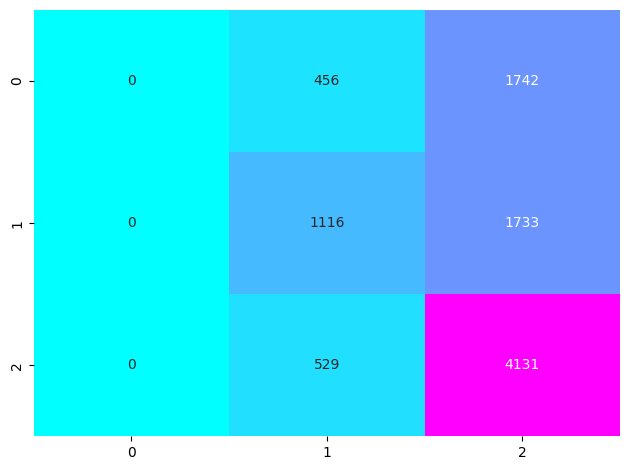

In [34]:

# Copiamos df_feat y preparamos target
df_model = df_feat.copy()

# Encode target (win/draw/loss)
le_result = LabelEncoder()
df_model["target_enc"] = le_result.fit_transform(df_model["result"])
print("Classes:", le_result.classes_)

# Features: fuerza de cada equipo
X = df_model[[
    "home_winrate", "home_gf", "home_ga",
    "away_winrate", "away_gf", "away_ga"
]]
y = df_model["target_enc"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)

# Modelo baseline: regresión logística multiclase
logreg = LogisticRegression(max_iter=1000)  # multinomial por default desde sklearn 1.5
logreg.fit(X_train, y_train)

# Predicciones
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)


# Métricas
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Log Loss:", log_loss(y_test, y_prob))

print("\nClassification Report:\n", 
      classification_report(y_test, y_pred, 
                          target_names=le_result.classes_,
                          zero_division=0))

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="cool", cbar=False)

plt.tight_layout()
plt.show()

##### 4) Evaluación de Resultados: Análisis cuantitativo y cualitativo del rendimiento de los modelos utilizando métricas apropiadas. Se deben interpretar los resultados en el contexto del problema original.